In [1]:
import pandas as pd
import healpy as hp
import numpy as np
import ligo.skymap
import argparse
import matplotlib.pyplot as plt

from matplotlib import rcParams
from pathlib import Path
from ligo.skymap import io, kde, postprocess
from ligo.skymap.plot.marker import reticle

import h5py


In [35]:
f1 = h5py.File("/fred/oz016/Chayan/GW-SkyLocator/evaluation/skymaps/BBH/Injection_run_BBH_3_det_design_test_Gaussian_KDE_test_GPU_0.hdf", "r")
probs = f1["Probabilities"][()]
ra_preds = f1["RA_samples"][()]
dec_preds = f1["Dec_samples"][()]
ra_test = f1["RA_test"][()]
dec_test = f1["Dec_test"][()]

f1.close()


In [46]:
skymap, metadata = io.fits.read_sky_map('/fred/oz016/Chayan/GW-SkyLocator/evaluation/skymaps/BBH/Test_new_BN_test_GPU_0.fits', nest=None)
nside = hp.npix2nside(len(skymap))


Text(1, 1, '50% area: 94 deg²\n90% area: 412 deg²')

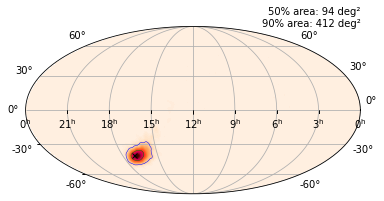

In [47]:
from astropy.coordinates import SkyCoord
# Convert to probability per square degree
deg2perpix = hp.nside2pixarea(nside, degrees=True)
probperdeg2 = skymap / deg2perpix

ax = plt.axes(projection="astro hours mollweide")
ax.grid()

event_ra = ra_test[0]
event_de = dec_test[0]

vmax = probperdeg2.max()
vmin = probperdeg2.min()
ax.imshow_hpx((probperdeg2, 'ICRS'), nested=True, vmin=vmin, vmax=vmax, cmap='cylon')
confidence_levels = 100 * postprocess.find_greedy_credible_levels(skymap)
contours = ax.contour_hpx((confidence_levels, 'ICRS'), nested=metadata['nest'],linewidths=0.5,levels=[50,90],colors=['green','blue'])
#cs = postprocess.contour(m, [50,90], degrees=True)
ax.plot_coord(SkyCoord(event_ra, event_de, unit='rad'), 'x',markeredgecolor='black', markersize=5)

text = []
pp = np.round([50,90]).astype(int)
#ii = np.round(np.searchsorted(np.sort(cls),[50,90]) * deg2perpix).astype(int)
ii_90 = np.sum(confidence_levels <= 90) * hp.nside2pixarea(nside, degrees=True)
ii_50 = np.sum(confidence_levels <= 50) * hp.nside2pixarea(nside, degrees=True)
ii = np.round([ii_50,ii_90]).astype(int)
for i, p in zip(ii, pp):
            # FIXME: use Unicode symbol instead of TeX '$^2$'
            # because of broken fonts on Scientific Linux 7.
            text.append(u'{:d}% area: {:d} deg²'.format(p, i, grouping=True))
ax.text(1, 1, '\n'.join(text), transform=ax.transAxes, ha='right')
